In [456]:
#### import global modules
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from yaml import safe_load
import google.oauth2.credentials
from google.cloud import bigquery
import gc

# Set global vars
pth_project = Path(os.getcwd().split('notebooks')[0])
pth_data = pth_project / 'data'
pth_queries = pth_project / 'core' / 'queries'
pth_creds = pth_project / 'conf' / 'local' / 'project_config.yaml'
sys.path.insert(0, str(pth_project))
d_project_config = safe_load(pth_creds.open())
# d_params = safe_load((pth_project / 'core' / 'parameters' / 'common.yaml').open())['data_extract']

# import local modules
from core.utils.gcp import connect_bq_services
# from core.etl.extract import extract_bq_data, extract_pr_codes, format_conv_df, filter_convs

# Connect to google services
bq_client = connect_bq_services(d_project_config['gcp-project-name'])
pd.options.display.max_rows = 100

In [457]:
def extract_bq_data(bq_client, sql=None, pth_query=None):
    if sql is not None:
        df = bq_client.query(sql).to_dataframe()
    elif pth_query is not None:
        sql = pth_query.read_text()
        df = bq_client.query(sql).to_dataframe()
    else:
        raise ValueError('`sql` or `pth_query` should be set')  
    return df

In [458]:
Query='''


DECLARE
  start_dt_snpsht DATE DEFAULT '2022-10-15';
DECLARE
  end_dt_snpsht DATE DEFAULT '2023-01-15';
DECLARE
  churn_dt_snpsht_start DATE DEFAULT '2023-01-15';
DECLARE
  churn_dt_snpsht_end DATE DEFAULT '2023-02-28';  


WITH date_sql as (

SELECT 
    DATE_TRUNC(DATE_SUB(start_dt_snpsht, INTERVAL 3 month), month) AS eligibility_date 


)



,Customer_Base as (select * from `divgpras-pr-579355.SHS.SHS_churn_model_base_score_data_oct2022_jan2023`)

, ADC_BP as ( 
select *,(Best_Practices_1+Best_Practices_2+Best_Practices_3+Best_Practices_4+Best_Practices_5+Best_Practices_6) as Best_Practice_All
from 

(
  -- #1 from_item
  SELECT 
    customer_id,
    best_practices_id,
     case when best_practices_ind=True then 1 else 0 end as Best_practices_flag,

  FROM `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_best_practice`
  where DATE(dt_last_calculate_utc) <= end_dt_snpsht
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_id,best_practices_id ORDER BY last_updt_ts DESC) = 1
)
PIVOT
(
  -- #2 aggregate
  sum(Best_practices_flag) AS Best_Practices
  -- #3 pivot_column
  FOR best_practices_id in (1,2,3,4,5,6)
)

)


,ADC_arming AS (

With date_sql as (
select  count(distinct date(date)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)<= end_dt_snpsht and date(date)>= start_dt_snpsht

)

select 
    id_cust as customer_id
    ,sum(count_arm_commands) as sum_arm_commands
    ,sum(count_disarm_commands) as sum_disarm_commands
    ,count (distinct date(date)) as number_days_arming_disarming
    , (select count_of_dates from date_sql ) as count_of_dates_arming
    , round(count (distinct date(date))*100/(select max(count_of_dates) from date_sql),0) as arming_consistency
    , round(sum(count_arm_commands)/(count (distinct date(date))),0) as Avg_arm_per_day
    ,round(sum(count_disarm_commands)/(count (distinct date(date))),0) as Avg_disarm_per_day
from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)<= end_dt_snpsht and date(date)>= start_dt_snpsht
group by customer_id
order by number_days_arming_disarming desc

)


, ADC_login as (

with date_sql as (
select  count(distinct date(login_dt_utc)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)<= end_dt_snpsht and date(login_dt_utc)>= start_dt_snpsht

)

select customer_id,sum(login_count) as sum_login_count,count (distinct date(login_dt_utc)) as number_of_login_days, (select count_of_dates from date_sql ) as count_of_dates_login, round(count (distinct date(login_dt_utc))*100/(select max(count_of_dates) from date_sql),0) as login_consistency, round(sum(login_count)/(count (distinct date(login_dt_utc))),0) as Avg_login_per_day
from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)<= end_dt_snpsht and date(login_dt_utc)>= start_dt_snpsht
group by customer_id
order by login_consistency desc



)


, cte_product_mix AS (
  
SELECT distinct ffh_prod.bacct_bus_bacct_num AS ban,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd IN ('SING', 'HSIC', 'TTV', 'SMHM', 'STV', 'DIIC','C') THEN ffh_prod.pi_prod_instnc_typ_cd ELSE NULL END) AS product_mix_all,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'HSIC' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS hsic_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'SING' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS sing_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'SMHM' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS shs_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'TTV'  THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS ttv_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'STV'  THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS stv_count,
         COUNT(DISTINCT CASE WHEN ffh_prod.pi_prod_instnc_typ_cd = 'DIIC' THEN ffh_prod.bus_prod_instnc_id ELSE NULL END) AS diic_count   
         FROM `cio-datahub-enterprise-pr-183a.ent_cust_cust.bq_prod_instnc_snpsht` AS ffh_prod
   
   WHERE DATE(ffh_prod.prod_instnc_ts) = end_dt_snpsht
     AND ffh_prod.pi_prod_instnc_stat_cd = 'A' --Active Products
     AND ffh_prod.consldt_cust_typ_cd = 'R' --Regular (not Business)
     AND ffh_prod.pi_prod_instnc_typ_cd IN 
         (
           'DIIC', --Dialup
           'HSIC', --High Speed
           'SING', --Home Phone
           'SMHM', --Smart Home
           'STV',  --Satelite
           'TTV'   --TV
         )
GROUP BY ffh_prod.bacct_bus_bacct_num
--QUALIFY ROW_NUMBER() OVER (PARTITION BY ffh_prod.bacct_bus_bacct_num ORDER BY ffh_prod.prod_instnc_ts ) = 1
order by ffh_prod.bacct_bus_bacct_num
)



, ARPU_Calculation as(

with ARPU_full as (
SELECT
  distinct billg_acct_num AS ban,
  EXTRACT(YEAR
  FROM
    bill.bill_dt)||'-'||LPAD(CAST(EXTRACT(MONTH
      FROM
        bill.bill_dt) AS STRING), 2, '0') AS bill_year_month,
  sum(bill.rid_unit_chrg_amt) as ARPU_SMHM,
  sum(tot_inv_amt) as ARPU_FFH
  FROM
  `cio-datahub-enterprise-pr-183a.ent_cust_bill.bq_wln_inv_sum_view` bill
WHERE
  DATE(bill.bill_dt)>=  start_dt_snpsht
  and DATE(bill.bill_dt)<= end_dt_snpsht
  group by ban,bill_year_month
)

select ban, round(avg(ARPU_SMHM),0) as Avg_SMHM_ARPU,round(avg(ARPU_FFH),0) as Avg_FFH_ARPU 
from ARPU_full group by ban

)


,Deact_list as (

select distinct Telus_Cust_ID,SMHM_Churn from 
(select  distinct cast (CUST_ID as string) as Telus_Cust_ID, 1 as SMHM_Churn, PARSE_DATE('%d%h%Y',SUBSTR(ACTIVITY_DATE, 0,9)) as churn_date from `divgpras-pr-579355.SHS.SMHM_Deact_Dec2022_Feb2023`)
where churn_date> churn_dt_snpsht_start and churn_date<=churn_dt_snpsht_end


)


select cb.*,bp.*,arm.* ,lg.*,prod_mix.*,ARPU.*,Deacts.*
from Customer_Base cb
left join ADC_BP bp
on cb.customer_id=bp.customer_id
left join ADC_arming arm
on cb.customer_id=arm.customer_id
left join ADC_login lg
on cb.customer_id=lg.customer_id
left join cte_product_mix as prod_mix
on cb.BAN=prod_mix.ban
left join ARPU_Calculation as ARPU
on cb.BAN=ARPU.ban
left join Deact_list as Deacts
on cb.dealer_customer_id=Deacts.Telus_Cust_ID

'''

In [459]:
DF=extract_bq_data(bq_client, sql=Query)

In [460]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360097 entries, 0 to 360096
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   360097 non-null  Int64  
 1   dealer_customer_id            360097 non-null  object 
 2   primary_login_id              360097 non-null  Int64  
 3   dealer_name                   360097 non-null  object 
 4   join_date                     360097 non-null  object 
 5   account_type_name             360097 non-null  object 
 6   customer_type_name            360097 non-null  object 
 7   Package                       360097 non-null  object 
 8   Tenure_months                 360097 non-null  Int64  
 9   BAN                           360097 non-null  Int64  
 10  cust_bus_cust_id              360097 non-null  object 
 11  contract_start_date           319404 non-null  object 
 12  contract_end_date             360097 non-nul

In [461]:
DF.head()

,customer_id,dealer_customer_id,primary_login_id,dealer_name,join_date,account_type_name,customer_type_name,Package,Tenure_months,BAN,...,sing_count,shs_count,ttv_count,stv_count,diic_count,ban_2,Avg_SMHM_ARPU,Avg_FFH_ARPU,Telus_Cust_ID,SMHM_Churn
0,6931637,46462378,8053939,TELUS Communications Inc.,2019-01-28,Security System,Customer,Monitored,48,601407725,...,0,1,1,0,0,601407725.000000000,65.000000000,174.000000000,None,<NA>
1,7527516,2600905,8779809,TELUS Communications Inc.,2019-06-21,Security System,Customer,Monitored,43,212525033,...,0,1,1,0,1,212525033.000000000,60.000000000,115.000000000,None,<NA>
2,6140673,98351083,7068264,TELUS Communications Inc.,2018-04-21,Security System,Customer,Monitored,57,603603134,...,0,1,0,0,0,603603134.000000000,50.000000000,52.000000000,None,<NA>
3,8895242,100544009,10451224,TELUS Communications Inc.,2020-04-04,Security System,Customer,Monitored,33,604221667,...,0,1,0,0,0,604221667.000000000,60.000000000,63.000000000,None,<NA>
4,6846485,1772209,7945738,TELUS Communications Inc.,2018-12-24,Security System,Customer,Monitored,49,603176697,...,0,1,0,1,0,603176697.000000000,52.000000000,192.000000000,None,<NA>


In [462]:
DF['SMHM_Churn'].fillna(0,inplace=True)

In [463]:
# DF['churn_date'].fillna(0,inplace=True)

In [464]:
DF['SMHM_Churn'].value_counts()

0    355931
1      4166
Name: SMHM_Churn, dtype: Int64

In [465]:
# DF['churn_date'].value_counts()

In [466]:
# DF['churn_date'].min()

In [467]:
DF['SMHM_Churn'].value_counts(normalize=True)*100

0    98.84309
1     1.15691
Name: SMHM_Churn, dtype: Float64

In [468]:
DF['shs_count'].value_counts()

1     357451
2       2537
3         97
4          8
5          2
11         1
6          1
Name: shs_count, dtype: Int64

In [469]:
DF['BAN'].value_counts()

601407725    1
603573557    1
603572992    1
200683560    1
605588046    1
            ..
601365191    1
601772594    1
603741301    1
605596057    1
605588778    1
Name: BAN, Length: 360097, dtype: Int64

In [470]:
DF=DF.drop_duplicates()

In [471]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360097 entries, 0 to 360096
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   360097 non-null  Int64  
 1   dealer_customer_id            360097 non-null  object 
 2   primary_login_id              360097 non-null  Int64  
 3   dealer_name                   360097 non-null  object 
 4   join_date                     360097 non-null  object 
 5   account_type_name             360097 non-null  object 
 6   customer_type_name            360097 non-null  object 
 7   Package                       360097 non-null  object 
 8   Tenure_months                 360097 non-null  Int64  
 9   BAN                           360097 non-null  Int64  
 10  cust_bus_cust_id              360097 non-null  object 
 11  contract_start_date           319404 non-null  object 
 12  contract_end_date             360097 non-nul

In [472]:
# BAN_list=DF['BAN'].value_counts().rename_axis('BAN').reset_index(name='unique_counts')

In [473]:
# BAN_list_2=BAN_list[BAN_list.unique_counts>1]

In [474]:
# BAN_list_2

In [475]:
# DF[DF['BAN']==604371757]
# .to_csv('Data_testing.csv',index=False)

In [476]:
config= bigquery.job.LoadJobConfig()

# config._properties['timePartitioning'] = {'field': 'Month_Year'}
config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

Table_BQ = 'SHS.SHS_churn_model_score_data_Oct2022_Jan2023'

bq_table_instance= bq_client.load_table_from_dataframe(DF, Table_BQ,job_config=config)

In [477]:
Query_score_data= '''

select * from `divgpras-pr-579355.SHS.SHS_churn_model_score_data_Oct2022_Jan2023`

'''

In [478]:
DF=extract_bq_data(bq_client, sql=Query_score_data)

In [479]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360097 entries, 0 to 360096
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   360097 non-null  Int64  
 1   dealer_customer_id            360097 non-null  object 
 2   primary_login_id              360097 non-null  Int64  
 3   dealer_name                   360097 non-null  object 
 4   join_date                     360097 non-null  object 
 5   account_type_name             360097 non-null  object 
 6   customer_type_name            360097 non-null  object 
 7   Package                       360097 non-null  object 
 8   Tenure_months                 360097 non-null  Int64  
 9   BAN                           360097 non-null  Int64  
 10  cust_bus_cust_id              360097 non-null  object 
 11  contract_start_date           319404 non-null  object 
 12  contract_end_date             360097 non-nul

In [480]:
ID_cols=['customer_id','dealer_customer_id','BAN']
ignore_cols=['primary_login_id','dealer_name','join_date','account_type_name','customer_type_name','cust_bus_cust_id'
             ,'contract_start_date','contract_end_date','customer_id_1','customer_id_2','customer_id_3','ban_1','ban_2'
             ,'BAN_3','sum_arm_commands','sum_disarm_commands','number_days_arming_disarming','count_of_dates_arming'
             ,'sum_login_count','number_of_login_days','count_of_dates_login','shs_count','Telus_Cust_ID']

Target_col=['SMHM_Churn']

In [481]:
DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])
DF['Avg_FFH_ARPU']=pd.to_numeric(DF['Avg_FFH_ARPU'])

In [482]:
num_cols=DF.select_dtypes(include=np.number).columns.tolist()
cat_cols=DF.select_dtypes(exclude=np.number).columns.tolist()

num_cols_features=list(set(num_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
cat_cols_features=list(set(cat_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
feature_cols=cat_cols_features+num_cols_features

In [483]:
DF[feature_cols].isnull().sum() * 100 / len(DF[feature_cols])

Package                   0.000000
contract_end_status       0.000000
Best_Practices_1         22.325096
arming_consistency       55.941038
Tenure_months             0.000000
sing_count                0.000000
stv_count                 0.000000
Avg_login_per_day        19.867147
Best_Practices_3         22.325096
Avg_FFH_ARPU              0.434605
Avg_arm_per_day          55.941038
diic_count                0.000000
Best_Practices_2         22.325096
hsic_count                0.000000
login_consistency        19.867147
Avg_disarm_per_day       55.941038
Contract_start_months    11.300566
Best_Practices_4         22.325096
Best_Practice_All        22.325096
Avg_SMHM_ARPU             0.483481
Best_Practices_6         22.325096
ttv_count                 0.000000
product_mix_all           0.000000
Best_Practices_5         22.325096
dtype: float64

In [484]:
def impute_missing_values(dataset=DF):
    
    for cols in dataset.columns:
        if dataset[cols].dtype == np.dtype('O'):
            # df.loc[np.isnan(df["Age"]), 'Age'] = rand1
            #dataset.loc[dataset[cols].isnull(), cols]="Missing_category"
            dataset[cols]=dataset[cols].fillna("Missing_category",inplace=False)
        else:
            dataset[cols]=dataset[cols].fillna(0,inplace=False)
            #dataset.loc[dataset[cols].isnull(), cols]=0
    return dataset

 
DF[feature_cols]=impute_missing_values(dataset=DF[feature_cols])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [485]:
DF['SMHM_Churn'].value_counts()

0    355931
1      4166
Name: SMHM_Churn, dtype: Int64

In [486]:
from pickle import dump,load
import warnings
import json
import joblib
## reading Intial feature list 
with open('Intial_feature_columns.json') as json_file:
    intial_feature_cols = json.load(json_file)


## reading final feature list 
with open('Final_feature_columns.json') as json_file:
    final_feature_cols = json.load(json_file)

In [487]:
X_test_df= pd.get_dummies(DF[intial_feature_cols],prefix_sep='__')


In [488]:
def add_missing_dummy_columns(d, cols_req_model):
    ''' 
    This function adds missing columns to the data so that the model doesn't fail.
    d is the Dataset. 
    cols_req_model is the list of columns required by the model.
    
    '''
    missing_cols = list(set(cols_req_model) - set(d.columns))
    print('Adding columns', missing_cols, 'to the data and populating them with 0.')
    for c in missing_cols:
        d[c] = 0


def remove_extra_columns(d,cols_req_model):
    
    ''' 
    This function drops extra columns from the data so that the model doesn't fail.
    d is the Dataset. 
    cols_req_model is the list of columns required by the model.
    
    '''
    extra_cols= list(set( d.columns ) - set( cols_req_model ))
    print('Dropping', extra_cols, 'columns from the data.')
    d = d.drop(extra_cols, axis=1)
    return d

In [489]:
add_missing_dummy_columns(X_test_df,final_feature_cols)


Adding columns [] to the data and populating them with 0.


In [490]:
X_test_df=remove_extra_columns(X_test_df,final_feature_cols)


Dropping [] columns from the data.


In [491]:
X_test_df=X_test_df.reindex(columns=final_feature_cols,fill_value=0)

In [492]:
model_filename='XGB_SMHM_SMHM_churn_model_20230317_065805.pkl'
modle_pickle=joblib.load(model_filename)


In [493]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer

def Capture_Rate_1stSD(ground_truth, prediction):
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    #print("data shape:", ground_truth.shape)

    prediction_df = pd.DataFrame(prediction, columns=["prob_of_predict_1"])
    # print(prediction_df.head())
    y_df = pd.DataFrame(ground_truth, columns=['target'])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))
    # Calculate lift on validation data
    v1 = prediction_with_label_df[['target', 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))
    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')['target'].transform(np.sum)
    vl2 = vl1.drop(['target', 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(
    vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    #vl2['Capture Rate_defintion'] = vl2['Freq']/vl2.iloc[19, 'Cumm Sum']
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()

    # this is lift csv
    # vl2.to_csv("/lift_chart_{0}.csv".format(today))
    # vl2.to_csv(
    # f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    # print(f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    #print("Training process completed success")
    Magic_score= round(vl2.iloc[0, 6],2)
    print("Cumm Capture Rate on 1st SD is: ", Magic_score)
    #vl2[vl2['SD'] == 1, 'Lift'].iloc[0]
    return Magic_score



def lift_calc_pd(model, X_test, y_test,target_column): # , model_path
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    prediction = model.predict_proba(X_test)
    print("output shape", prediction.shape)
    print("y_test shape:", y_test.shape)
    #Total_Actual_positive_targets=sum(y_test[target_column])
    #print('Total_Actual_positive_targets:',Total_Actual_positive_targets)


    prediction_df = pd.DataFrame(
    prediction, columns=['prob_of_predict_0', 'prob_of_predict_1'])
    y_df = pd.DataFrame(y_test, columns=[target_column])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))


    # Calculate lift on validation data
    v1 = prediction_with_label_df[[target_column, 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))


    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')[target_column].transform(np.sum)
    vl2 = vl1.drop([target_column, 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()
    # vl2['Capture_Rate_Defintion']= vl2['Freq']*100/Total_Actual_positive_targets
    # vl2['Cummu_Capture_Rate_Defintion']= vl2['Capture_Rate_Defintion'].cumsum()
    return pd.DataFrame(vl2)

In [494]:
Test_lift=lift_calc_pd(model=modle_pickle,X_test=X_test_df
,y_test=DF[Target_col[0]],target_column=Target_col[0])

output shape (360097, 2)
y_test shape: (360097,)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [495]:
Target_col[0]

'SMHM_Churn'

In [496]:
DF[Target_col[0]].value_counts()

0    355931
1      4166
Name: SMHM_Churn, dtype: Int64

In [497]:
Test_lift

,SD,Freq,Cumm Sum,Lift,Cumm Lift,Capture Rate,Cummu Capture Rate
95932,1,1258,1258,6.039366,6.039366,30.196831,30.196831
24562,2,446,1704,2.141143,4.090254,10.705713,40.902544
116394,3,335,2039,1.608257,3.262922,8.041287,48.943831
209373,4,267,2306,1.281805,2.767643,6.409025,55.352856
244026,5,247,2553,1.18579,2.451272,5.928949,61.281805
56265,6,191,2744,0.916947,2.195551,4.584734,65.866539
6012,7,191,2935,0.916947,2.012893,4.584734,70.451272
183449,8,127,3062,0.609698,1.837494,3.048488,73.49976
260415,9,139,3201,0.667307,1.707473,3.336534,76.836294
300906,10,127,3328,0.609698,1.597696,3.048488,79.884782


In [498]:
Test_lift.to_csv('SHS_Churn_model_lift.csv',index=False)

In [499]:
ID_DF=DF[ID_cols+Target_col]
X_data=pd.concat([ID_DF,X_test_df],axis=1)

In [500]:
X_data.head()

,customer_id,dealer_customer_id,BAN,SMHM_Churn,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
0,15246138,105410571,605633656,0,0,0.0,0,0,0,0,...,1.0,0,0.0,2,0,1,0,0,0,1
1,15189805,105109332,605546030,0,0,0.0,0,0,0,0,...,13.0,0,0.0,2,1,0,0,0,1,0
2,15242585,91314553,602484792,0,1,0.0,1,0,0,0,...,4.0,0,0.0,4,0,1,0,0,1,0
3,15184545,105344831,605620953,0,0,0.0,0,0,0,0,...,12.0,0,0.0,2,0,1,0,0,1,0
4,15207931,98054605,603481535,0,1,0.0,1,0,0,0,...,11.0,0,0.0,4,0,1,0,0,1,0


In [501]:
X_data.columns

Index(['customer_id', 'dealer_customer_id', 'BAN', 'SMHM_Churn', 'ttv_count',
       'Avg_arm_per_day', 'hsic_count', 'Best_Practices_3', 'Best_Practices_5',
       'Tenure_months', 'Best_Practices_1', 'Contract_start_months',
       'Avg_FFH_ARPU', 'Best_Practices_6', 'Best_Practice_All',
       'Avg_login_per_day', 'stv_count', 'Avg_SMHM_ARPU', 'Best_Practices_2',
       'Best_Practices_4', 'diic_count', 'Avg_disarm_per_day',
       'login_consistency', 'sing_count', 'arming_consistency',
       'product_mix_all', 'contract_end_status__contract_expired',
       'contract_end_status__contract_expiring_after_90_days',
       'contract_end_status__contract_expiring_within_90_days',
       'Package__Monitored', 'Package__Smart_Automation_Plus',
       'Package__Smart_Camera'],
      dtype='object')

In [502]:
print(X_data.Package__Smart_Camera.sum()*100/X_data.shape[0])
print(X_data.Package__Smart_Automation_Plus.sum()*100/X_data.shape[0])
print(X_data.Package__Monitored.sum()*100/X_data.shape[0])

12.579943737381873
26.974120861878884
60.445935400739245


In [503]:
x_SC=X_data[X_data.Package__Smart_Camera==1]
# y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
Test_lift.to_csv('Smart_Camera_Lift.csv',index=False)

output shape (45300, 2)
y_test shape: (45300,)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [504]:
x_SC=X_data[X_data.Package__Smart_Automation_Plus==1]
# y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
Test_lift.to_csv('Smart_Automation_Plus_Lift.csv',index=False)

output shape (97133, 2)
y_test shape: (97133,)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [505]:
x_SC=X_data[X_data.Package__Monitored==1]
# y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=modle_pickle,X_test=x_SC[final_feature_cols]
,y_test=x_SC[Target_col[0]],target_column=Target_col[0])
Test_lift.to_csv('Monitored_Lift.csv',index=False)

output shape (217664, 2)
y_test shape: (217664,)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


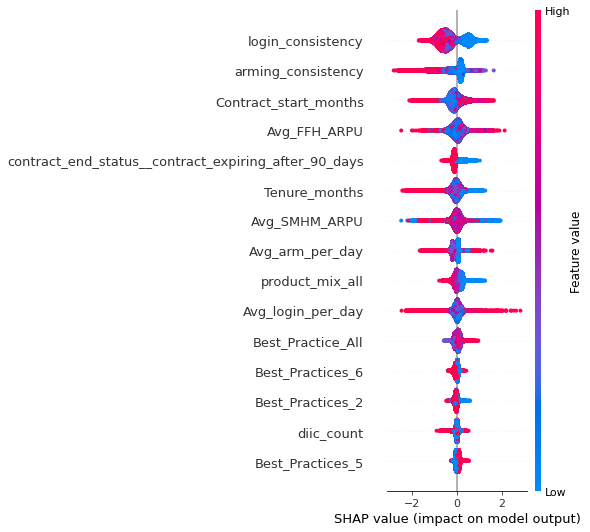

In [76]:
import shap
x_SC=X_data[X_data.Package__Monitored==1]
# model_shap = XGB_final_model.best_estimator_
explainer = shap.TreeExplainer(modle_pickle)
shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
#%%

shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


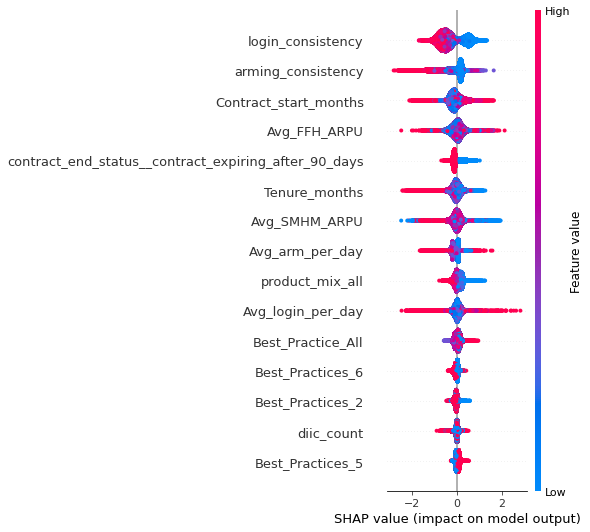

In [132]:
import shap
x_SC=X_data[X_data.Package__Monitored==1]
# model_shap = XGB_final_model.best_estimator_
explainer = shap.Explainer(modle_pickle)
shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
# #%%

shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)

In [134]:
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

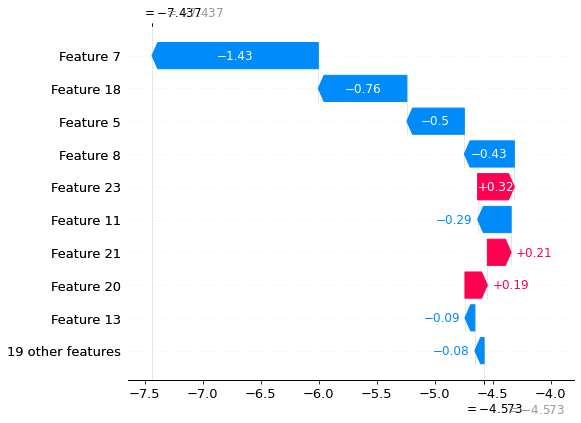

In [136]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0])

In [91]:
np.round(shap_values[[idx]],2)

array([[ 0.05, -0.01, -0.04,  0.01, -0.02, -0.5 ,  0.02, -1.43, -0.43,
         0.  , -0.  , -0.29,  0.  , -0.09, -0.04, -0.01,  0.02,  0.01,
        -0.76, -0.01,  0.19,  0.21, -0.04,  0.32, -0.01, -0.01,  0.  ,
        -0.  ]], dtype=float32)

In [82]:
shap_values[idx]

array([-0.00896824, -0.01416761, -0.0324664 , -0.10342016, -0.05265706,
       -0.191954  ,  0.0682723 ,  0.29299593, -0.038459  ,  0.00365203,
        0.05811919, -0.04408898,  0.00229947,  0.05522108, -0.06962357,
       -0.00146709,  0.00443751,  0.08840989,  0.6319278 , -0.00144093,
        0.19786465,  0.02906586, -0.01526133,  0.22006883, -0.00699333,
       -0.0088415 ,  0.00311295, -0.00177546], dtype=float32)

In [80]:
shap_values

array([[ 5.02743274e-02, -8.66256095e-03, -3.75816487e-02, ...,
        -5.00636874e-03,  5.67193783e-05, -1.40747346e-03],
       [-8.96823965e-03, -1.41676068e-02, -3.24664004e-02, ...,
        -8.84149875e-03,  3.11294966e-03, -1.77545880e-03],
       [ 5.68864830e-02, -5.18046366e-03,  2.72408780e-03, ...,
        -1.36064544e-01, -1.29662575e-02, -2.54508480e-02],
       ...,
       [ 4.25516069e-03,  2.79614292e-02, -2.79478058e-02, ...,
        -6.36552740e-03,  1.23803935e-03,  2.86317500e-03],
       [ 4.38194796e-02, -1.35105819e-01,  1.83827989e-02, ...,
        -6.74797921e-03,  8.83232744e-04,  2.73458473e-03],
       [-4.77848351e-02, -2.66736507e-01, -5.50260022e-02, ...,
        -6.63910806e-03,  5.91974240e-04, -3.48989910e-04]], dtype=float32)

In [79]:
x_SC[final_feature_cols].iloc[[idx]]

,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,Best_Practices_1,Contract_start_months,Avg_FFH_ARPU,Best_Practices_6,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
2,1,0.0,1,0,0,18,0,43,295.0,0,...,0.0,0,0.0,3,1,0,0,1,0,0


In [93]:
X_data.columns

Index(['customer_id', 'dealer_customer_id', 'BAN', 'SMHM_Churn', 'ttv_count',
       'Avg_arm_per_day', 'hsic_count', 'Best_Practices_3', 'Best_Practices_5',
       'Tenure_months', 'Best_Practices_1', 'Contract_start_months',
       'Avg_FFH_ARPU', 'Best_Practices_6', 'Best_Practice_All',
       'Avg_login_per_day', 'stv_count', 'Avg_SMHM_ARPU', 'Best_Practices_2',
       'Best_Practices_4', 'diic_count', 'Avg_disarm_per_day',
       'login_consistency', 'sing_count', 'arming_consistency',
       'product_mix_all', 'contract_end_status__contract_expired',
       'contract_end_status__contract_expiring_after_90_days',
       'contract_end_status__contract_expiring_within_90_days',
       'Package__Monitored', 'Package__Smart_Automation_Plus',
       'Package__Smart_Camera'],
      dtype='object')

In [101]:
x_SC=X_data[(X_data.Package__Monitored==1) & (X_data.SMHM_Churn==1)]


In [108]:
final_feature_cols

['ttv_count',
 'Avg_arm_per_day',
 'hsic_count',
 'Best_Practices_3',
 'Best_Practices_5',
 'Tenure_months',
 'Best_Practices_1',
 'Contract_start_months',
 'Avg_FFH_ARPU',
 'Best_Practices_6',
 'Best_Practice_All',
 'Avg_login_per_day',
 'stv_count',
 'Avg_SMHM_ARPU',
 'Best_Practices_2',
 'Best_Practices_4',
 'diic_count',
 'Avg_disarm_per_day',
 'login_consistency',
 'sing_count',
 'arming_consistency',
 'product_mix_all',
 'contract_end_status__contract_expired',
 'contract_end_status__contract_expiring_after_90_days',
 'contract_end_status__contract_expiring_within_90_days',
 'Package__Monitored',
 'Package__Smart_Automation_Plus',
 'Package__Smart_Camera']

In [117]:
pd.DataFrame(np.round(shap_values[[idx]],2),columns=final_feature_cols)

,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,Best_Practices_1,Contract_start_months,Avg_FFH_ARPU,Best_Practices_6,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
0,0.03,0.02,-0.03,-0.05,-0.07,0.2,0.03,-1.53,-0.05,-0.09,...,0.58,0.01,0.22,0.22,0.02,0.21,-0.03,-0.02,0.01,-0.0


In [119]:
pd.DataFrame(x_SC[final_feature_cols].iloc[[idx]])

,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,Best_Practices_1,Contract_start_months,Avg_FFH_ARPU,Best_Practices_6,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
1006,0,0.0,0,0,0,57,1,57,37.0,0,...,0.0,0,0.0,1,1,0,0,1,0,0


In [115]:
np.round(shap_values[[idx]],2).sum()

0.25

In [137]:
# plots the waterfall for the 6th observation. As optional input give waterfall_plot the number of features, in order to draw them all. Since all observations have the same number of features, the index of the second argument does not need to be adjusted.

In [138]:
shap_values.base

array([ 5.0274327e-02, -8.6625610e-03, -3.7581649e-02, ...,
        5.9197424e-04, -3.4898991e-04, -4.5731993e+00], dtype=float32)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


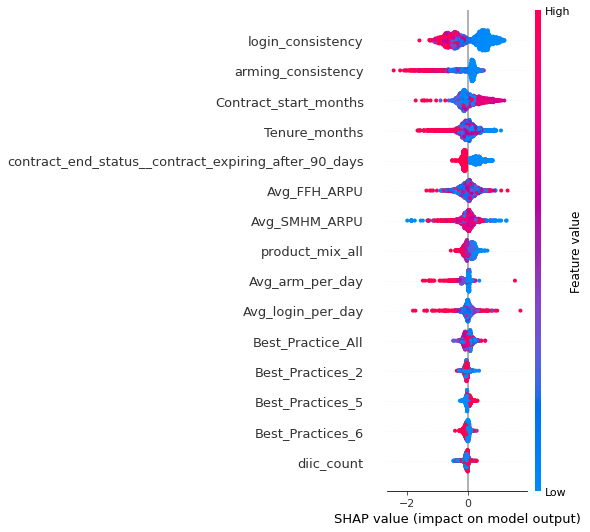

In [211]:
import shap
x_SC=X_data[(X_data.Package__Monitored==1) & (X_data.SMHM_Churn==1)]
# model_shap = XGB_final_model.best_estimator_
explainer = shap.Explainer(modle_pickle)
shap_values = explainer.shap_values(x_SC[final_feature_cols],check_additivity=False)
# #%%

shap.summary_plot(shap_values, features=x_SC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)

,customer_id,dealer_customer_id,BAN,SMHM_Churn,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
110,5258127,98343205,603583814,1,0,0.0,0,0,0,68,...,0.0,0,0.0,1,1,0,0,1,0,0


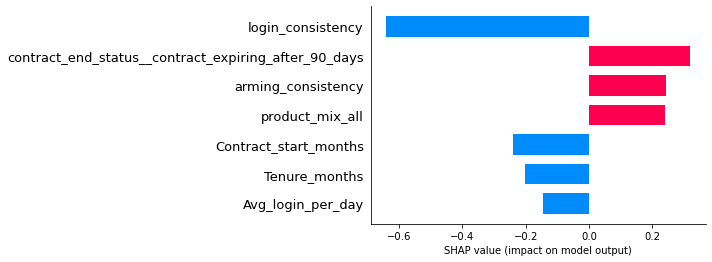

In [249]:
idx=10

shap.plots._bar.bar_legacy(shap_values[idx],feature_names=final_feature_cols,show=True)

In [250]:
x_SC[final_feature_cols].iloc[[idx]]

,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,Best_Practices_1,Contract_start_months,Avg_FFH_ARPU,Best_Practices_6,...,login_consistency,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera
439,1,0.0,1,0,0,53,1,135,163.0,0,...,1.0,0,0.0,3,1,0,0,1,0,0


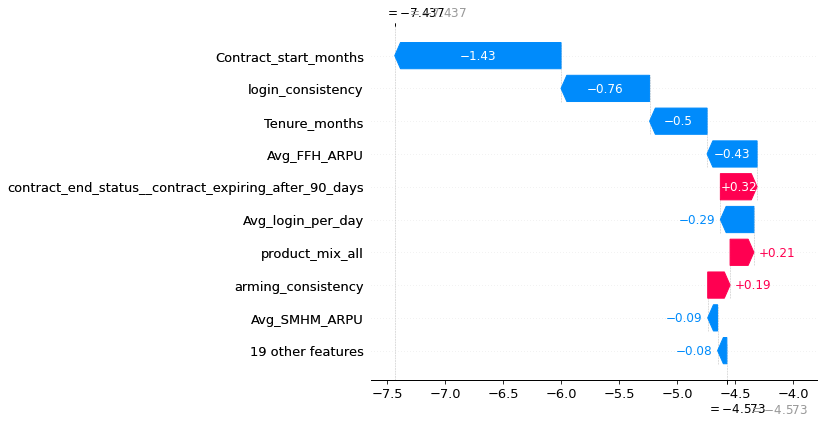

In [248]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[idx],feature_names=final_feature_cols,max_display=10)

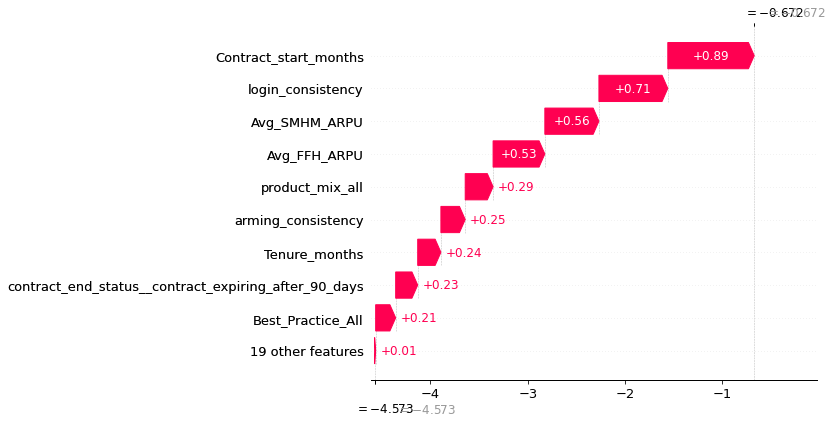

In [218]:
shap.summary_plot(shap_values[0], x_SC[final_feature_cols], plot_type="bar")

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [164]:
# shap.summary_plot(shap_values[1], x_SC[final_feature_cols].iloc[[idx]], plot_type="bar")

In [163]:
# shap.plots.bar(shap_values[0])

      customer_id dealer_customer_id        BAN  SMHM_Churn  ttv_count  \
1006      6074375           98317679  603588048           1          0   

      Avg_arm_per_day  hsic_count  Best_Practices_3  Best_Practices_5  \
1006              0.0           0                 0                 0   

      Tenure_months  ...  login_consistency  sing_count  arming_consistency  \
1006             57  ...                0.0           0                 0.0   

      product_mix_all  contract_end_status__contract_expired  \
1006                1                                      1   

      contract_end_status__contract_expiring_after_90_days  \
1006                                                  0      

      contract_end_status__contract_expiring_within_90_days  \
1006                                                  0       

      Package__Monitored  Package__Smart_Automation_Plus  \
1006                   1                               0   

      Package__Smart_Camera  
1006         

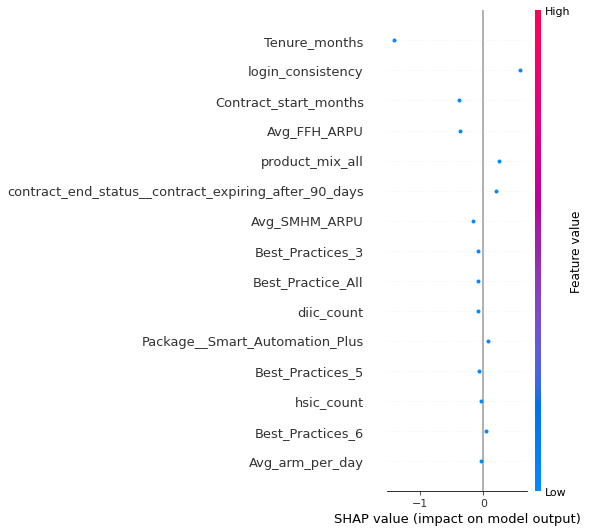

In [162]:
idx=20
print(x_SC.iloc[[idx]])
print(np.round(shap_values[[idx]],2))
shap.summary_plot(shap_values[[idx]], features=x_SC[final_feature_cols].iloc[[idx]]
, feature_names=final_feature_cols,show=True,max_display=15)

In [75]:
# DF.info()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


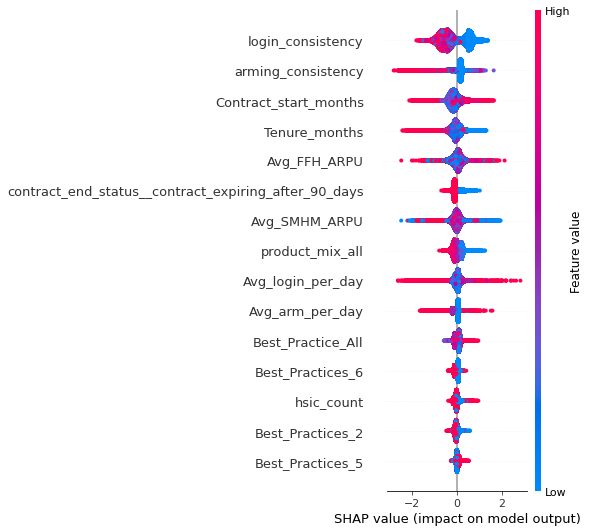

In [251]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer = shap.Explainer(modle_pickle)
shap_values = explainer.shap_values(X_test_df,check_additivity=False)
#%%

shap.summary_plot(shap_values, features=X_test_df
, feature_names=final_feature_cols,show=False,max_display=15)

In [252]:
X_test_df.columns

Index(['ttv_count', 'Avg_arm_per_day', 'hsic_count', 'Best_Practices_3',
       'Best_Practices_5', 'Tenure_months', 'Best_Practices_1',
       'Contract_start_months', 'Avg_FFH_ARPU', 'Best_Practices_6',
       'Best_Practice_All', 'Avg_login_per_day', 'stv_count', 'Avg_SMHM_ARPU',
       'Best_Practices_2', 'Best_Practices_4', 'diic_count',
       'Avg_disarm_per_day', 'login_consistency', 'sing_count',
       'arming_consistency', 'product_mix_all',
       'contract_end_status__contract_expired',
       'contract_end_status__contract_expiring_after_90_days',
       'contract_end_status__contract_expiring_within_90_days',
       'Package__Monitored', 'Package__Smart_Automation_Plus',
       'Package__Smart_Camera'],
      dtype='object')

In [253]:
# shap.plots.waterfall(shap_values[x])

In [506]:
result_churn_model=pd.DataFrame(modle_pickle.predict_proba(X_test_df) [:,1])

In [507]:
result_churn_model.mean()*100

0    1.083159
dtype: float32

In [508]:
result_churn_model.head()


,0
0,0.288395
1,0.016539
2,0.024908
3,0.029068
4,0.018156


In [509]:
result_churn_model.columns=['Churn_score']

In [510]:
# All_cols= ID_cols + X_test_df.columns.to_list()
ID_DF=DF[ID_cols+Target_col]


In [511]:
Full_DF=pd.concat([ID_DF,X_test_df,result_churn_model],axis=1)

In [512]:
Full_DF.head()

,customer_id,dealer_customer_id,BAN,SMHM_Churn,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,...,sing_count,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera,Churn_score
0,15246138,105410571,605633656,0,0,0.0,0,0,0,0,...,0,0.0,2,0,1,0,0,0,1,0.288395
1,15189805,105109332,605546030,0,0,0.0,0,0,0,0,...,0,0.0,2,1,0,0,0,1,0,0.016539
2,15242585,91314553,602484792,0,1,0.0,1,0,0,0,...,0,0.0,4,0,1,0,0,1,0,0.024908
3,15184545,105344831,605620953,0,0,0.0,0,0,0,0,...,0,0.0,2,0,1,0,0,1,0,0.029068
4,15207931,98054605,603481535,0,1,0.0,1,0,0,0,...,0,0.0,4,0,1,0,0,1,0,0.018156


In [513]:
# Output_DF_1=Output_DF.merge(TEST_DF_FULL[ID_cols],on=ID_cols,how='left')

In [514]:
# Output_DF=pd.concat([ID_DF,result_churn_model],axis=1)

In [515]:
# Output_DF.head()

In [516]:
# Output_DF.columns=ID_cols+['Churn_score']

In [517]:
Full_DF['Churn_SD'] = pd.qcut(Full_DF['Churn_score'].rank(method='first',ascending=False), q=20, labels=False)+1


In [518]:
Full_DF_HRC=Full_DF[Full_DF['Churn_SD']==1]

In [519]:
Full_DF_HRC['Churn_score'].mean()*100


8.285373449325562

In [520]:
Full_DF_HRC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18005 entries, 0 to 360054
Data columns (total 34 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   customer_id                                            18005 non-null  Int64  
 1   dealer_customer_id                                     18005 non-null  object 
 2   BAN                                                    18005 non-null  Int64  
 3   SMHM_Churn                                             18005 non-null  Int64  
 4   ttv_count                                              18005 non-null  Int64  
 5   Avg_arm_per_day                                        18005 non-null  float64
 6   hsic_count                                             18005 non-null  Int64  
 7   Best_Practices_3                                       18005 non-null  Int64  
 8   Best_Practices_5                             

In [320]:
pd.DataFrame(Full_DF_HRC.groupby(['Package__Smart_Camera']).agg(
    
    Customer_count= ('customer_id','nunique'),
    # Churn_total_telus=('Churn_score',lambda x: x.sum()),
    Churn_rate_telus=('Churn_score',lambda x: x.mean()*100),
    # Churn_total=('Churn_flag',lambda x: x.sum()),
    # Churn_rate=('Churn_flag',lambda x: x.mean()*100)
).reset_index())

,Package__Smart_Camera,Customer_count,Churn_rate_telus
0,0,13877,7.909124
1,1,4128,9.553614


In [321]:
pd.DataFrame(Full_DF_HRC.groupby(['Package__Monitored']).agg(
    
    Customer_count= ('customer_id','nunique'),
    # Churn_total_telus=('Churn_score',lambda x: x.sum()),
    Churn_rate_telus=('Churn_score',lambda x: x.mean()*100),
    # Churn_total=('Churn_flag',lambda x: x.sum()),
    # Churn_rate=('Churn_flag',lambda x: x.mean()*100)
).reset_index())

,Package__Monitored,Customer_count,Churn_rate_telus
0,0,10276,8.682484
1,1,7729,7.759222


In [333]:
Full_DF_HRC['Churn_score'].mean()*100

8.286155760288239

In [335]:
Full_DF_HRC['Churn_score'].max()

0.7994893

In [334]:
Full_DF['Churn_score'].mean()*100

1.083146221935749

In [521]:
Full_DF_HRC=Full_DF_HRC.sort_values('Churn_score',ascending=False)

In [522]:
Full_DF_HRC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18005 entries, 217688 to 95932
Data columns (total 34 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   customer_id                                            18005 non-null  Int64  
 1   dealer_customer_id                                     18005 non-null  object 
 2   BAN                                                    18005 non-null  Int64  
 3   SMHM_Churn                                             18005 non-null  Int64  
 4   ttv_count                                              18005 non-null  Int64  
 5   Avg_arm_per_day                                        18005 non-null  float64
 6   hsic_count                                             18005 non-null  Int64  
 7   Best_Practices_3                                       18005 non-null  Int64  
 8   Best_Practices_5                         

In [523]:
Full_DF_HRC.to_csv('SHS_Model_score.csv',index=False)

In [524]:
config= bigquery.job.LoadJobConfig()

# config._properties['timePartitioning'] = {'field': 'Month_Year'}
config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

Table_BQ = 'SHS.SHS_Model_score'

bq_table_instance= bq_client.load_table_from_dataframe(Full_DF_HRC, Table_BQ,job_config=config)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


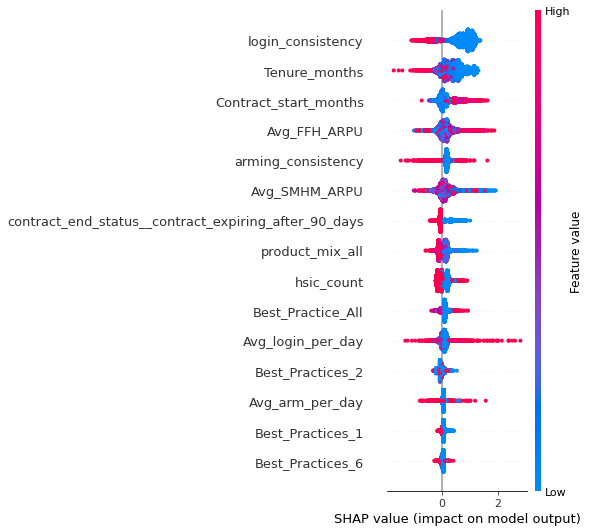

In [337]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer = shap.Explainer(modle_pickle)
shap_values_local = explainer.shap_values(Full_DF_HRC[final_feature_cols],check_additivity=False)
#%%

shap.summary_plot(shap_values_local, features=Full_DF_HRC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)


# shap.plots.bar(shap_values_local[0]) # For the first observation


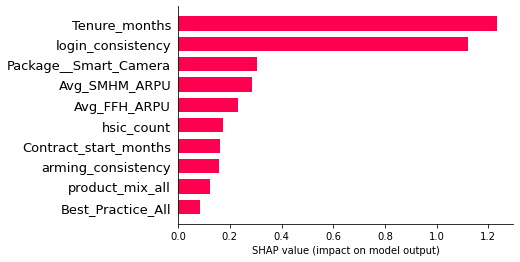

In [447]:
idx=50
shap.plots._bar.bar_legacy(shap_values_local[idx],feature_names=final_feature_cols,show=True,max_display=10)

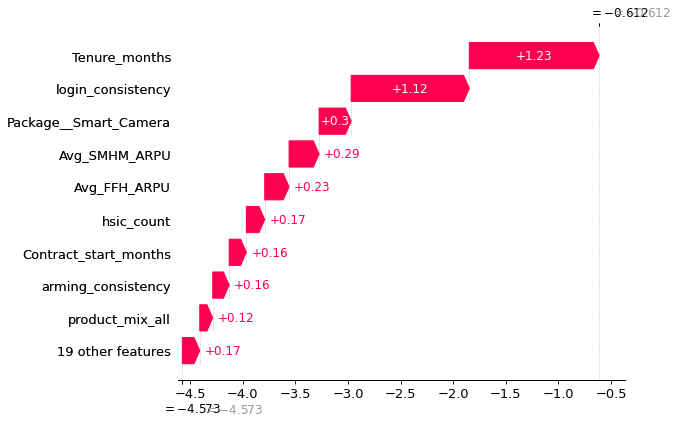

In [450]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_local[idx],feature_names=final_feature_cols,max_display=10)

In [451]:
Full_DF_HRC[ID_cols+['Churn_score','login_consistency','Tenure_months','Contract_start_months','Avg_FFH_ARPU','Avg_SMHM_ARPU','product_mix_all','Package__Smart_Camera','Package__Smart_Automation_Plus']].iloc[idx]

customer_id                        15236342
dealer_customer_id                105402816
BAN                               605634186
Churn_score                        0.351526
login_consistency                       1.0
Tenure_months                             0
Contract_start_months                     0
Avg_FFH_ARPU                            0.0
Avg_SMHM_ARPU                           0.0
product_mix_all                           2
Package__Smart_Camera                     1
Package__Smart_Automation_Plus            0
Name: 58570, dtype: object

In [406]:
Full_DF_HRC['Churn_score'].iloc[idx]

0.3515264

In [342]:
shap.force_plot(explainer.expected_value, shap_values_local[idx], features=Full_DF_HRC[final_feature_cols].iloc[[idx]], feature_names=final_feature_cols)

In [453]:
Full_DF_LRC=Full_DF[Full_DF['Churn_SD']==20]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


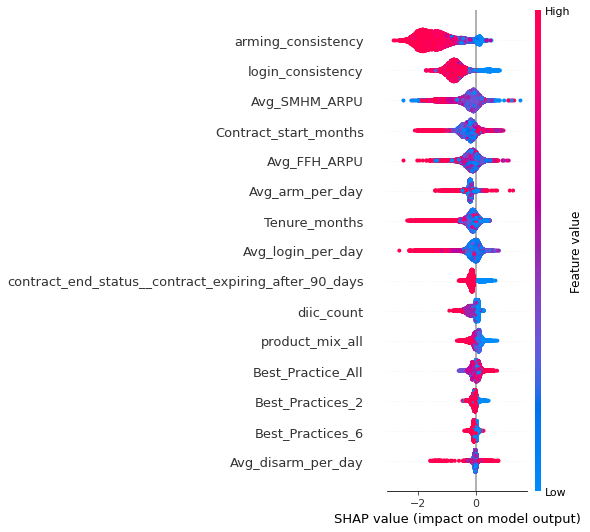

In [454]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer_LRC = shap.Explainer(modle_pickle)
shap_values_local_LRC = explainer.shap_values(Full_DF_LRC[final_feature_cols],check_additivity=False)
#%%

shap.summary_plot(shap_values_local_LRC, features=Full_DF_LRC[final_feature_cols]
, feature_names=final_feature_cols,show=False,max_display=15)

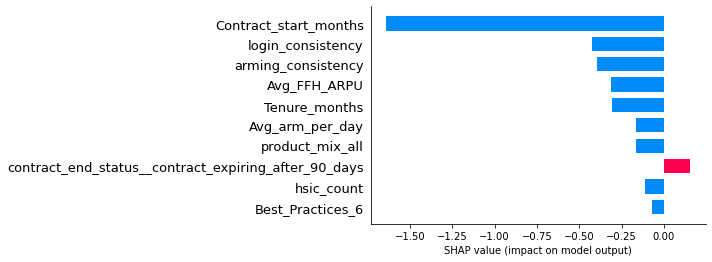

In [455]:
idx=50
shap.plots._bar.bar_legacy(shap_values_local_LRC[idx],feature_names=final_feature_cols,show=True,max_display=10)

In [343]:
# shap.initjs()

# shap.force_plot(explainer.expected_value[1], shap_values_local[1], Full_DF[final_feature_cols])

In [344]:

# shap.plots.bar(shap_values_local[0]) # For the first observation
# # shap.plots.waterfall(shap_values_local[1])

In [167]:
import shap
from shap import Explainer, Explanation
from shap import waterfall_plot
X_pred=Full_DF[final_feature_cols]
idx = 9
explainer = Explainer(modle_pickle)
sv = explainer(X_pred.iloc[[idx]])
# model_shap = XGB_final_model.best_estimator_
# explainer = shap.TreeExplainer(modle_pickle)
# shap_values_local = explainer.shap_values(Full_DF[final_feature_cols],check_additivity=False)
#%%

exp = Explanation(
    sv.values[:, :, 1],         # class to explain
    sv.base_values[:, 1],
    data=FX_pred.iloc[[idx]].values,   # corrected, pass the row of interest as df
    feature_names=final_feature_cols,
)
waterfall(exp[0])               # pretend you have only 1 data point which is 0th 

# shap.summary_plot(shap_values_local, features=Full_DF[final_feature_cols]
# , feature_names=final_feature_cols,show=False,max_display=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [161]:
Full_DF[final_feature_cols].loc[[0]]

KeyError: "None of [Int64Index([0], dtype='int64')] are in the [index]"

In [166]:
Full_DF.iloc[[0]]

,customer_id,dealer_customer_id,BAN,SMHM_Churn,ttv_count,Avg_arm_per_day,hsic_count,Best_Practices_3,Best_Practices_5,Tenure_months,...,arming_consistency,product_mix_all,contract_end_status__contract_expired,contract_end_status__contract_expiring_after_90_days,contract_end_status__contract_expiring_within_90_days,Package__Monitored,Package__Smart_Automation_Plus,Package__Smart_Camera,Churn_score,Churn_SD
9,14874964,103411504,604915974,0,0,0.0,0,0,0,2,...,0.0,2,1,0,0,0,1,0,0.144503,1


In [ ]:
exp = Explanation(sv[:,:,6], sv.base_values[:,6], X_train, feature_names=None)

In [145]:
shap_values[0]

array([-4.42003720e-02, -5.20775979e-03,  7.32300282e-02, -1.17910991e-03,
       -8.40417389e-03, -3.18821430e-01,  1.62857193e-02, -1.39016831e+00,
       -2.04607844e-01, -2.94067096e-02, -2.19816975e-02,  8.26461017e-02,
        7.04055943e-04, -8.92780442e-03,  3.89393717e-02, -1.91082302e-02,
        1.04699265e-02,  9.14853625e-03, -2.99767315e-01, -8.34878534e-03,
        2.93430507e-01, -1.50675774e-01, -5.26572056e-02,  5.14006197e-01,
       -3.90582643e-02,  1.53252622e-02,  3.55479687e-01, -4.02908213e-03],
      dtype=float32)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!